In [1]:
import os
import zipfile
import urllib.request
import shutil

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
import tarfile

def extract_tar_gz(file_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"Extraient {file_path}...")
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Extret a: {extract_to}")
    else:
        print(f"a extret: {extract_to}")

# Descomprimir
extract_tar_gz("../data/images.tar.gz", "../data/images")
extract_tar_gz("../data/annotations.tar.gz", "../data/annotations")


a extret: ../data/images
a extret: ../data/annotations


In [3]:
import shutil
from sklearn.model_selection import train_test_split

trainval_file = "../data/annotations/annotations/trainval.txt"
images_dir = "../data/images/images"

with open(trainval_file, "r") as f:
    lines = f.readlines()

train_lines, val_lines = train_test_split(lines, test_size=0.2, random_state=42)

def reorganize(lines, split="train"):
    for line in lines:
        parts = line.strip().split()
        image_name = parts[0] + ".jpg"
        species = int(parts[2])  # 1 = cat, 2 = dog
        
        label = "cats" if species == 1 else "dogs"

        src_path = os.path.normpath(os.path.join(images_dir, image_name))
        dst_dir = os.path.join("../data", split, label)
        dst_path = os.path.join(dst_dir, image_name)

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)

# Reorganitzar imatges
reorganize(train_lines, split="train")
reorganize(val_lines, split="val")
print("Imatges reorganitzades correctament.")


Imatges reorganitzades correctament.


In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transformació bàsica
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Datasets i DataLoaders
dataset_train = ImageFolder("../data/train", transform=transform)
dataset_val = ImageFolder("../data/val", transform=transform)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)


In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Carrega ResNet18 preentrenada i treu la capa final
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
for param in resnet18.parameters():
    param.requires_grad = False

class CustomResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SoftMax(nn.Module):
    def __init__(self, input_size=128*128*3, num_classes=2):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        out = self.linear(x)
        return out

In [7]:


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # 128x128 input, 2 pools (halven la mida 128 -> 64 -> 32)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # batch x 16 x 64 x 64
        x = self.pool(F.relu(self.conv2(x)))  # batch x 32 x 32 x 32
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:

#imatges 128x128 RGB
softmax_model = SoftMax(input_size=128*128*3, num_classes=2)

simplecnn_model = SimpleCNN(num_classes=2)

model_resnet18 = CustomResNetClassifier().to(device)

print(softmax_model)
print(simplecnn_model)
print(model_resnet18)


SoftMax(
  (linear): Linear(in_features=49152, out_features=2, bias=True)
)
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
CustomResNetClassifier(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer_softmax = optim.Adam(softmax_model.parameters(), lr=0.001)
optimizer_simplecnn = optim.Adam(simplecnn_model.parameters(), lr=0.001)
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.001)


In [10]:
train_loader = DataLoader(dataset_train, batch_size=5, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=5, shuffle=False)

589
Iter 1, Loss: 0.8590
Iter 301, Loss: 133.3928
Epoch 1, Loss: 248.0272, Accuracy: 0.8922
Iter 601, Loss: 4.2231
Iter 901, Loss: 109.1696
Epoch 2, Loss: 204.1316, Accuracy: 0.9124
Iter 1201, Loss: 7.7676
Iter 1501, Loss: 105.3679
Epoch 3, Loss: 193.9774, Accuracy: 0.9057
Iter 1801, Loss: 8.3746
Iter 2101, Loss: 105.8261
Epoch 4, Loss: 193.2015, Accuracy: 0.9043
Iter 2401, Loss: 15.5095
Iter 2701, Loss: 110.3661
Epoch 5, Loss: 184.5217, Accuracy: 0.9084
Maximum validation accuracy: 0.9123989218328841


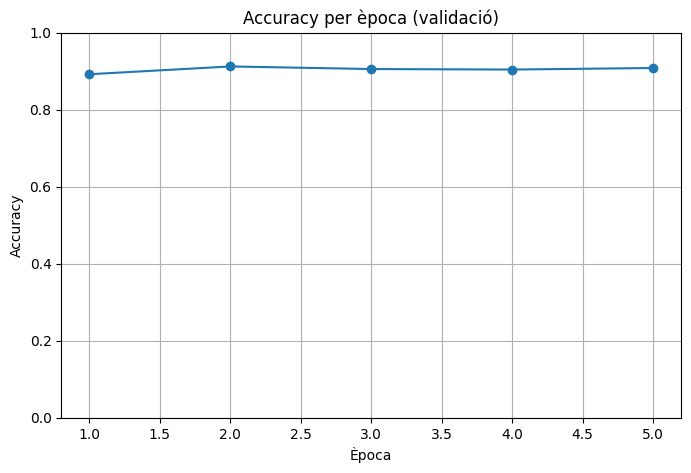

In [11]:
import matplotlib.pyplot as plt

max_accuracy = 0
n_epochs = 5
model = model_resnet18
optimizer = optimizer_resnet18
iteracions = 0
print(len(train_loader))

accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if iteracions % 300 == 0:
            print(f"Iter {iteracions+1}, Loss: {running_loss:.4f}")
        iteracions += 1

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy) 
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")

    if accuracy > max_accuracy:
        max_accuracy = accuracy

print("Maximum validation accuracy:", max_accuracy)

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs+1), accuracies, marker='o', linestyle='-')
plt.title("Accuracy per època (validació)")
plt.xlabel("Època")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [12]:
from PIL import Image
import torch

def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0) 

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    classes = ['cat', 'dog']  
    return classes[predicted.item()]


In [13]:
import random

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

idx_to_class = {0: "cat", 1: "dog"}

val_dir = "../data/val"
all_images = []

for label_dir in os.listdir(val_dir):
    full_path = os.path.join(val_dir, label_dir)
    if os.path.isdir(full_path):
        for fname in os.listdir(full_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(full_path, fname))

sample_images = random.sample(all_images, 5)

model.eval()
for img_path in sample_images:
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        label = idx_to_class[pred]

    print(f"{os.path.basename(img_path)} → Predicció: {label}")


Persian_158.jpg → Predicció: cat
american_bulldog_110.jpg → Predicció: dog
wheaten_terrier_101.jpg → Predicció: dog
beagle_170.jpg → Predicció: dog
Bengal_106.jpg → Predicció: cat


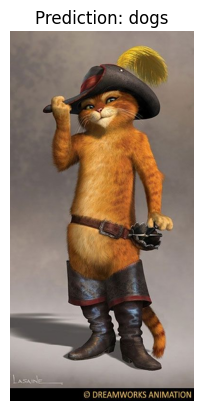

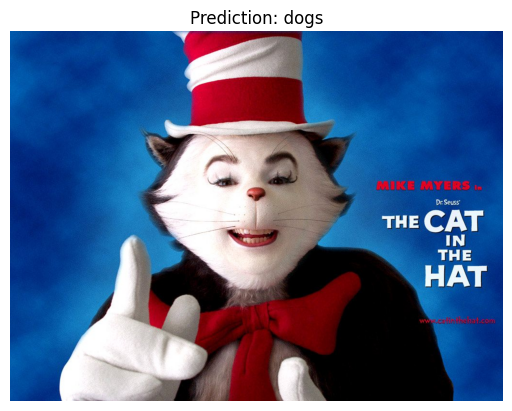

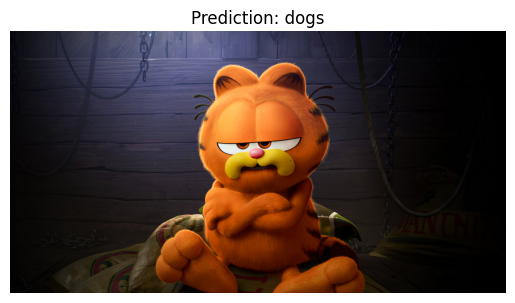

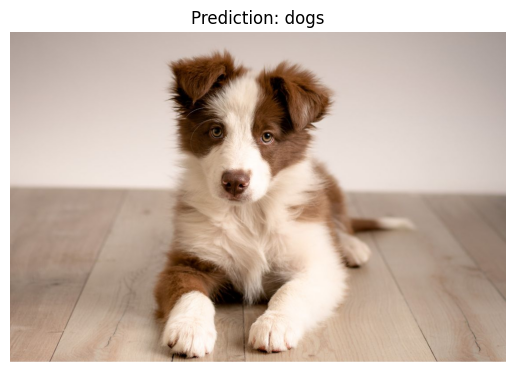

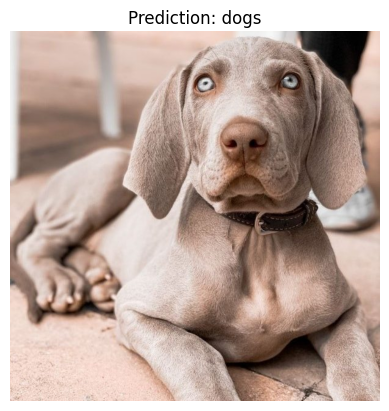

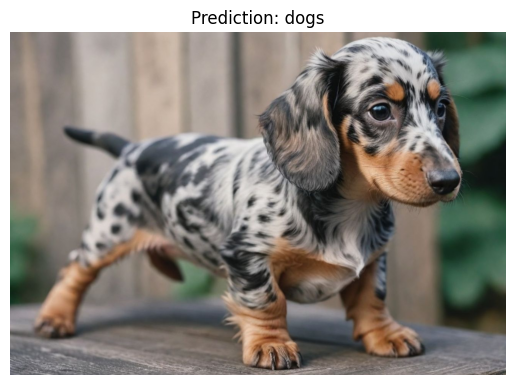

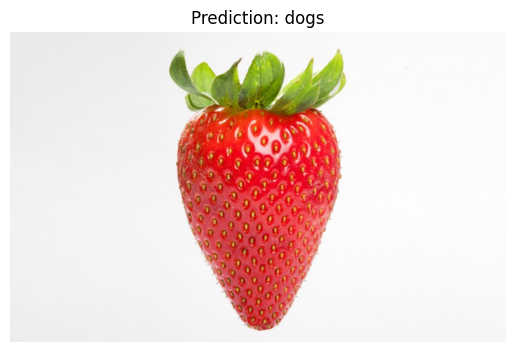

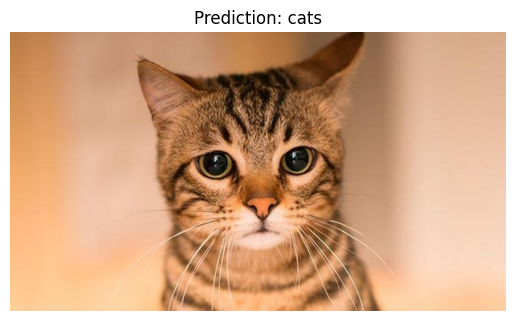

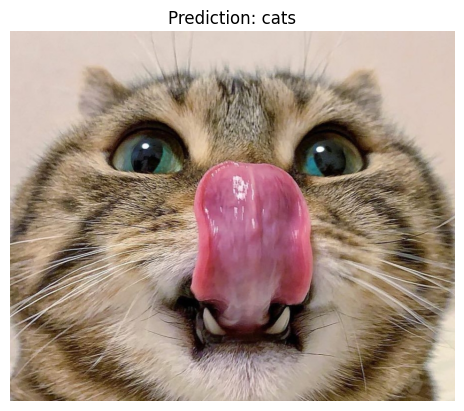

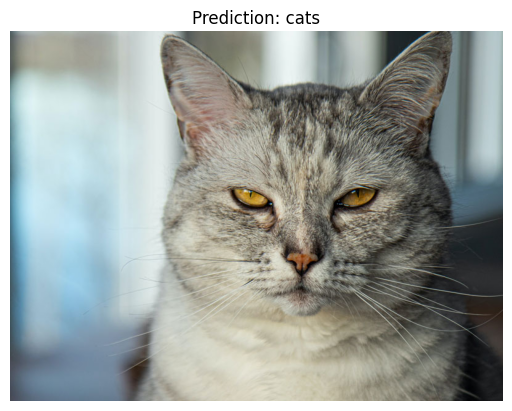

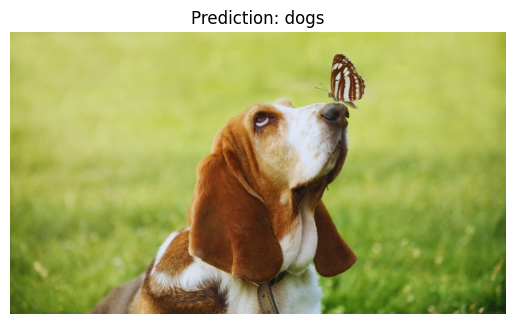

In [21]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageOps

def predict_image(img_path, model, transform, class_names=["cats", "dogs"]):
    image = ImageOps.exif_transpose(Image.open(img_path)).convert("RGB")
    input_tensor = transform(image).unsqueeze(0) 
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    return class_names[predicted.item()], image

directory_in_str = "../data/val/proves2"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

image_files = [f for f in os.listdir(directory_in_str) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

for filename in image_files:
    img_path = os.path.join(directory_in_str, filename)
    prediction, image = predict_image(img_path, model, transform)

    plt.imshow(image)
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")
    plt.show()
